#Использование статистического анализа формы в предварительной обработке температурно-модулированного отклика датчика газа на основе оксида металла для машинного обучения для улучшения селективности обнаружения газов в реальных атмосферных условиях

##Описание проекта
В данном проекте выполнены следующие шаги:
1. Рассмотрены данные, использованные в статье `Krivetskiy V. V. et al. "Statistical shape analysis pre-processing of temperature modulated metal oxide gas sensor response for machine learning improved selectivity of gases detection in real atmospheric conditions" // Sensors and Actuators B: Chemical, 2021, V. 329, P. 1-14.`

2. Предварительная обработка данных. Применены методы статистического анализа формы для обработки откликов датчика, включая нормализацию данных

3. Моделирование с помощью машинного обучения: Разработана и обучена модели машинного обучения на обработанных данных.

4. Тестирование и валидация: Проведены тестирование и валидация модели для оценки их эффективности и точности.

5. Интерпретация результатов и обзор направления дальнейшего исследования

# 1. Предварительная обработка данных
## 1.1 Загрузка данных

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

Установка дополнительных библиотек

In [4]:
#!pip install PyWavelets

Импорт необходимых библиотек

In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from numpy import polyfit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.decomposition import PCA
from pywt import wavedec

Переменная обозначающая название выбранного сенсора

In [6]:
SENSOR = 'S3'

Функции для предварительной обработки исходных "сырых" данных.

**1. Функция data_bug_fix(bad_table)** \
Эта функция принимает на вход таблицу с данными и выполняет следующие действия:

Заменяет все значения inf (бесконечность) на 0.
Заменяет все значения NaN (нечисловые значения) на 0.
Возвращает исправленную таблицу. \

**2. Функция default_preprocessing(x_table)**
Эта функция выполняет предварительную обработку данных:

Применяет логарифмическое преобразование к входной таблице x_table, используя data_bug_fix для устранения проблем с данными.
Вычитает минимальное значение из каждой строки, чтобы нормализовать данные (привести их к диапазону от 0 до максимума).
Возвращает обработанную таблицу. \
**3. Функция get_poly_coeffs(input_vec, a_coef=9)** \
Эта функция получает коэффициенты полинома для входного вектора input_vec:
* Использует функцию polyfit из NumPy для подгонки полинома заданной степени a_coef к нормализованным данным.
* Возвращает коэффициенты полинома и остатки (разницу между фактическими и предсказанными значениями). \

**4. Функция poly_extracter(x_table, poly_coef=9)**
\
Эта функция применяет get_poly_coeffs ко всем строкам входной таблицы x_table:

Нормализует каждую строку (делит на сумму).
Извлекает коэффициенты полинома для каждой строки.
Возвращает таблицу, содержащую только коэффициенты полинома. \
**5. Функция dataset_from_files(experiments_folder, output_folder, sensor='S3', dataset='train')** \
Эта функция отвечает за сбор данных из файлов, находящихся в указанной папке экспериментов, и сохранение их в предварительно обработанном виде:

Читает данные из папки с экспериментами, где каждая папка соответствует дате и времени эксперимента.
Для каждого файла извлекает данные с откликами датчиков и температурой, а также создает метки классов (one-hot encoding) для газов.
Объединяет все данные в одну таблицу для дальнейшего анализа.
Делит данные на обучающую и валидационную выборки (или тестовую, в зависимости от параметра dataset).
Сохраняет обработанные данные в выходной папке в виде CSV-файлов.

In [7]:
def data_bug_fix(bad_table):
    bad_table[np.abs(bad_table)==np.inf] = 0
    bad_table[np.isnan(bad_table)]=0
    return bad_table

def default_preprocessing(x_table):
    x_table_lg10 = data_bug_fix(np.log(x_table))
    out_table = x_table_lg10 - np.min(x_table_lg10, axis=1).reshape([-1,1])
    return out_table

#def get_poly_coeffs(input_vec, a_coef=9):
    #from scipy import polyfit
    #z1, resid, rank, singular, rcond = list(polyfit(np.arange(0,len(input_vec)),input_vec/np.sum(input_vec), a_coef, full=True))
#    z1, resid, _, _, _ = np.polyfit(np.arange(0, len(input_vec)), input_vec / np.sum(input_vec), a_coef, full=True)
#    return(z1, resid)

def get_poly_coeffs(input_vec, a_coef=9):
    z1, resid, rank, singular, rcond = list(polyfit(np.arange(0, len(input_vec)), input_vec / np.sum(input_vec), a_coef, full=True))
    return z1, resid


def poly_extracter(x_table, poly_coef=9):
    x_table_coefs = np.array(list(map(lambda x: get_poly_coeffs(x/np.sum(x), a_coef=poly_coef), x_table)))
    out_table = np.array([list(i[0]) for i in x_table_coefs])
    return out_table


def dataset_from_files(experiments_folder, output_folder, sensor='S3', dataset='train'):

	# INPUTS
	#experiments_folder - path to folder with experiment dated folders, by default: './methane-propane/methane-propane-raw_data/'
	    #following experiment folders at experiment_folder path should be exist:
	    # ['2018.12.12_20.14.18',
	    #  '2018.12.13_20.31.40',
	    #  '2018.12.14_20.53.45',
	    #  '2018.12.19_21.35.25',
	    #  '2018.12.20_21.36.43',
	    #  '2018.12.21_21.46.34',
	    #  '2019.01.11_15.51.25',
	    #  '2019.01.12_19.32.29',
	    #  '2019.01.14_19.58.00',
	    #  '2019.01.16_11.08.22',
	    #  '2019.01.18_15.19.45',
	    #  '2019.01.25_12.26.23',
	    #  '2019.01.27_12.47.08',
	    #  '2019.01.30_11.26.44',
	    #  '2019.01.31_20.25.57',
	    #  '2019.02.01_11.08.18',
	    #  '2019.02.20_22.18.39']
    #output_folder - path to folder with precessed files, by default: './methane-propane/training_data'
	#sensor - sensor string index, maybe 3 possible values: 'S1', 'S2', 'S3'
	#dataset - should data be randomly splitted to training and validating subsets. If not, "test" value should be selected.

	# OUTPUTS
	# there are 4 files types will be created: X, Xt Y, log
		# X - file containing sensor responses, no colnames and indexes. rows - samples, columns - features;
        # Xt - file containing temperature observations, no colnames and indexes. rows - samples, columns - features;
        # Y - file containing one-hot encoded classes, corresponding to each sample at X\Xt file, no colnames and indexes. rows - samples, columns - ['air', 'methane', 'propane'];
        # log - file containing information about each sample in X\Xt\Y files:
        	#experiment - name of experimnet folder (day and time info)
        	#gas - gas type: 'air', 'methane', 'propane';
        	#concentration - gas concentation, ppm;
        	#file - file name of observation series in experiment folder where sample was initially stored;
        	#total obs - total number of samples of selected observation series
        	#curr obs - the number of selected sample during observation series


    experiment_list = os.listdir(experiments_folder)[:6]
    if dataset=='test': experiment_list = os.listdir(experiments_folder)[6:]

    glob_cnt = 0
    log_arr_train = []

    for exper_cnt in experiment_list[:6]:
        gas_list = np.sort(os.listdir(os.path.join(experiments_folder, exper_cnt)))

        for gas_cnt in gas_list:
            conc_list = np.sort(os.listdir(os.path.join(experiments_folder, exper_cnt, gas_cnt)))

            for conc_cnt in conc_list:

                file_list = np.sort(os.listdir(os.path.join(experiments_folder, exper_cnt, gas_cnt, conc_cnt)))
                file_list_sensor = [i for i in file_list  if i.split('_')[0]==sensor]

                for file_cnt in file_list_sensor:
                    raw_file = np.array(pd.read_csv(os.path.join(experiments_folder,exper_cnt,gas_cnt,conc_cnt,file_cnt), header=None))
                    R_data = raw_file[list(range(1,raw_file.shape[0],2))]
                    T_data = raw_file[list(range(0,raw_file.shape[0],2))]

                    y_data = np.zeros([R_data.shape[0], 3])
                    y_data[:,np.where(gas_cnt==gas_list)[0][0]]=1



                    if glob_cnt==0:
                        out_xr = R_data.copy()
                        out_xt = T_data.copy()
                        out_y = y_data.copy()
                        log_arr_train = np.hstack([np.repeat(np.array([exper_cnt, gas_cnt, conc_cnt, file_cnt, R_data.shape[0]]).reshape([1,-1]),R_data.shape[0], axis=0), np.arange(R_data.shape[0]).reshape(-1,1)])

                    else:
                        out_xr = np.vstack([out_xr, R_data.copy()])
                        out_xt = np.vstack([out_xt, T_data.copy()])
                        out_y = np.vstack([out_y,y_data.copy()])

                        log_arr_train = np.vstack([log_arr_train, np.hstack([np.repeat(np.array([exper_cnt, gas_cnt, conc_cnt, file_cnt,  R_data.shape[0]]).reshape([1,-1]),R_data.shape[0], axis=0), np.arange(R_data.shape[0]).reshape(-1,1)])])


                    glob_cnt+=1


    os.makedirs(output_folder, exist_ok=True)

    if dataset=='train':
        X_train, X_val, y_train, y_val = train_test_split(out_xr, out_y, test_size=0.2, random_state=42)
        Xt_train, Xt_val, yt_train, yt_val = train_test_split(out_xt, out_y, test_size=0.2, random_state=42)

        log_arr_trn, log_arr_val, y_train2, y_val2 = train_test_split(log_arr_train,  out_y, test_size=0.2, random_state=42)

        np.savetxt(os.path.join(output_folder,sensor+'_X_train.csv'), X_train, delimiter=',')
        np.savetxt(os.path.join(output_folder,sensor+'_Xt_train.csv'), Xt_train, delimiter=',')
        np.savetxt(os.path.join(output_folder,sensor+'_X_val.csv'), X_val, delimiter=',')
        np.savetxt(os.path.join(output_folder,sensor+'_Xt_val.csv'), Xt_val, delimiter=',')
        np.savetxt(os.path.join(output_folder,sensor+'_Y_train.csv'), y_train, delimiter=',')
        np.savetxt(os.path.join(output_folder,sensor+'_Y_val.csv'), y_val, delimiter=',')
        pd.DataFrame(log_arr_trn, columns=['experiment', 'gas','concentration', 'file', 'total obs', 'curr obs']).to_csv(os.path.join(output_folder,sensor+'_log_train.csv'))
        pd.DataFrame(log_arr_val, columns=['experiment', 'gas','concentration', 'file', 'total obs', 'curr obs']).to_csv(os.path.join(output_folder,sensor+'_log_val.csv'))


    if dataset == 'test':

        np.savetxt(os.path.join(output_folder,sensor+'_X_test.csv'), out_xr, delimiter=',')
        np.savetxt(os.path.join(output_folder,sensor+'_Xt_test.csv'), out_xt, delimiter=',')
        np.savetxt(os.path.join(output_folder,sensor+'_Y_test.csv'), out_y, delimiter=',')
        pd.DataFrame(log_arr_train, columns=['experiment', 'gas','concentration', 'file', 'total obs', 'curr obs']).to_csv(os.path.join(output_folder,sensor+'_log_test.csv'))


Пути к каталогам данных

In [8]:
experiments_folder = '/content/drive/MyDrive/gas_sensor/raw_data/'
output_folder = '/content/drive/MyDrive/gas_sensor/my_merge/' + SENSOR

In [9]:
#Генерация объединенного датасета train
#dataset_from_files(experiments_folder, output_folder, sensor='S3', dataset='train')

In [10]:
#Генерация объединенного датасета test
#dataset_from_files(experiments_folder, output_folder, sensor='S3', dataset='test')

## 1.2 Обработка данных



In [11]:
plt.style.use('ggplot')
%matplotlib inline

In [12]:
DATASET_PATH = '/content/drive/MyDrive/gas_sensor/my_merge/' + SENSOR

In [13]:
X_train_df = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_X_train.csv'), header=None)
X_val_df = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_X_val.csv'), header=None)
X_test_df = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_X_test.csv'), header=None)

train_log = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_log_train.csv'),index_col=0)
val_log = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_log_val.csv'),index_col=0)
test_log = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_log_test.csv'),index_col=0)

In [14]:
Y_train_df = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_Y_train.csv'), header=None)
Y_val_df = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_Y_val.csv'), header=None)
Y_test_df = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_Y_test.csv'), header=None)

In [15]:
#filter first 5 observations from all datasets
X_train = np.array(X_train_df.loc[train_log.loc[train_log['curr obs']>4].index])
Y_train = np.array(Y_train_df.loc[train_log.loc[train_log['curr obs']>4].index])

X_val = np.array(X_val_df.loc[val_log.loc[val_log['curr obs']>4].index])
Y_val = np.array(Y_val_df.loc[val_log.loc[val_log['curr obs']>4].index])

X_test = np.array(X_test_df.loc[test_log.loc[test_log['curr obs']>4].index])
Y_test = np.array(Y_test_df.loc[test_log.loc[test_log['curr obs']>4].index])

In [16]:
#make default preprocessing steps: log10 and minimum substraction
X_train_lg10 = default_preprocessing(X_train)
X_val_lg10 = default_preprocessing(X_val)
X_test_lg10 = default_preprocessing(X_test)

1.2.1 Выходная зависимость сенсора

Построим временной ряд изменения сопротивления сенсора без обработки и применив логарифмический масштаб и нормализацию

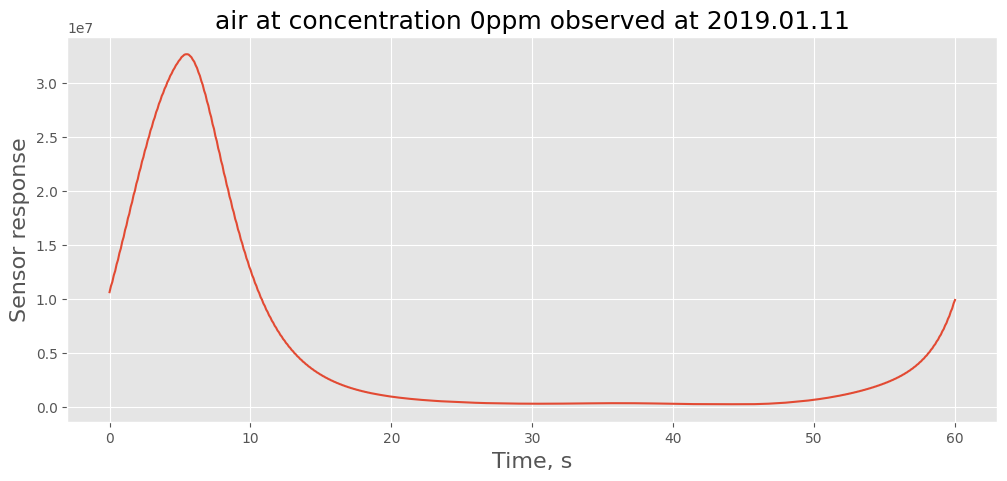

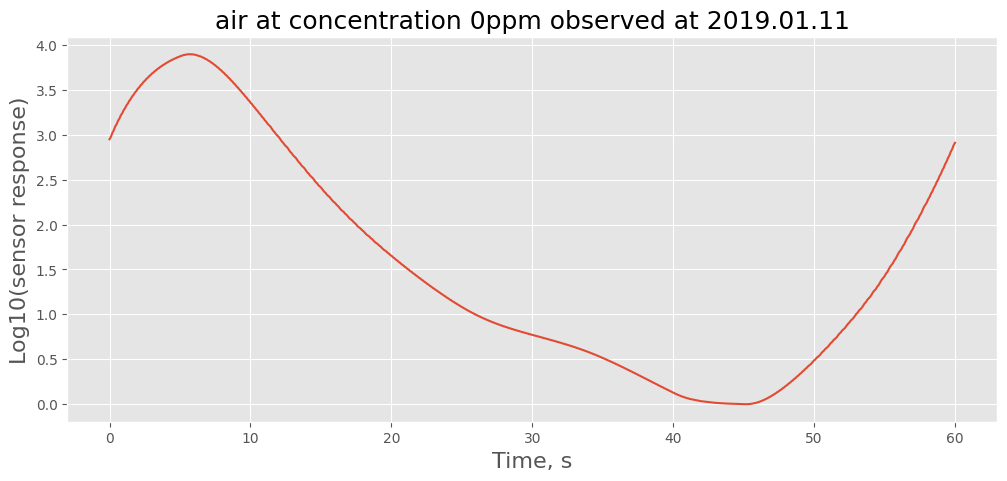

In [17]:
# let's make a plots of raw data sample
plt.rcParams['figure.figsize'] = (12,5)
row_number = np.random.randint(X_train_df.shape[0])
plt.plot(np.linspace(0,60, X_train_df.shape[1]), X_train_df.iloc[row_number])
plt.title("{gas} at concentration {concentration}ppm observed at {experiment}".format(\
                  gas=train_log.loc[row_number]['gas'],\
                  concentration=int(train_log.loc[row_number]['concentration']),\
                  experiment= train_log.loc[row_number]['experiment']).split('_')[0],\
                  fontsize = 18)
plt.ylabel('Sensor response', fontsize = 16), plt.xlabel('Time, s', fontsize = 16)
plt.show()

# and plot sample after default preprocessing
plt.rcParams['figure.figsize'] = (12,5)
plt.plot(np.linspace(0,60, X_train_lg10.shape[1]), X_train_lg10[row_number])
plt.title("{gas} at concentration {concentration}ppm observed at {experiment}".format(\
                  gas=train_log.loc[row_number]['gas'],\
                  concentration=int(train_log.loc[row_number]['concentration']),\
                  experiment= train_log.iloc[row_number]['experiment']).split('_')[0],\
                  fontsize = 18)
plt.ylabel('Log10(sensor response)', fontsize = 16), plt.xlabel('Time, s', fontsize = 16)
plt.show()

# 1.2.2 Полиномиальная аппроксимация

Для оценки необходимого порядка полинома мы будем использовать индекс AIC (Akaike Information Criterion), рассчитанный на обучающем массиве данных. Поскольку для решения конечной задачи используется нейронная сеть с полностью связным слоем:

Количество параметров модели = (порядок полинома) * (число нейронов в скрытом слое).
Ошибка рассчитывается как сумма квадратов отклонений между оригинальными сигналами датчиков и их аппроксимированными значениями.

Лучшая модель — это та, для которой значение индекса AIC минимально.

AIC — это критерий, который помогает определить, насколько хорошо модель объясняет данные, учитывая количество параметров. Меньшее значение AIC указывает на лучшую модель, которая обеспечивает хороший баланс между точностью и сложностью.
Порядок полинома определяет степень полинома, который используется для аппроксимации данных. Более высокий порядок может лучше подстраиваться под данные, но и увеличивает риск переобучения.
Скрытый слой нейронной сети отвечает за обработку данных и извлечение признаков. Чем больше нейронов в скрытом слое, тем больше параметров имеет модель, что также влияет на AIC.
Сумма квадратов ошибок (SSE) — это мера того, насколько хорошо модель соответствует данным. Чем меньше SSE, тем лучше модель.

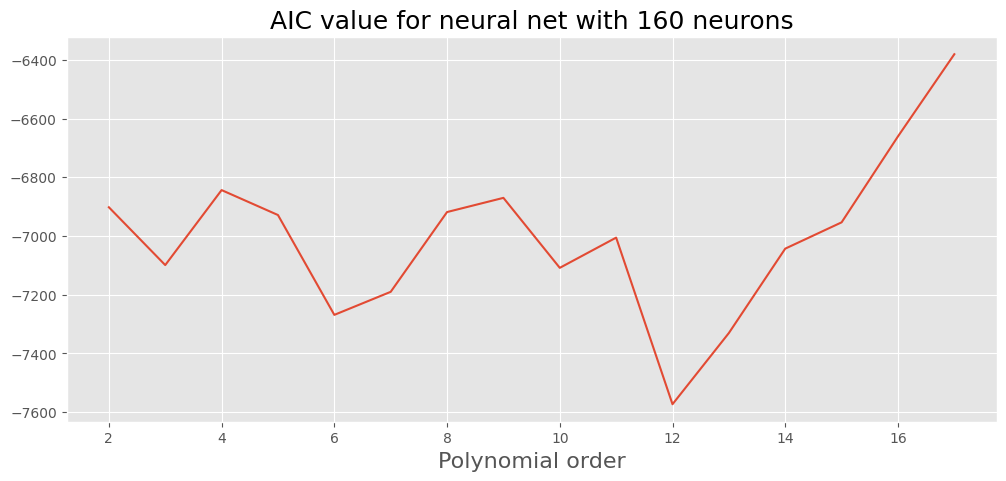

In [18]:
'''AICc = n * log(SSE/n) + (n + p) / (1 - (p + 2) / n)
SSE = Sum of Squared Errors for the training set
n = Number of training cases
p = Number of parameters (weights and biases)'''

NUM_HIDDEN = 160
results_list = []

for poly_coef in range(2, 18):
    # Process each input vector in X_train_lg10
    X_train_coefs = []
    X_resid = []
    for x in X_train_lg10:
        z1, resid = get_poly_coeffs(x / np.sum(x), poly_coef)
        X_train_coefs.append(z1)
        X_resid.append(resid)

    # Convert lists to arrays
    X_train_coefs = np.array(X_train_coefs)
    X_resid = np.array(X_resid)

    # Calculate AIC
    SSE = np.mean(X_resid)
    n = X_train.shape[1]
    p = poly_coef * NUM_HIDDEN

    AIC = n * (np.log(2 * np.pi * SSE / n) + 1) + 2 * p
    results_list.append([p, AIC])

plt.plot(np.arange(2,18), np.array(results_list)[:,1])
plt.title('AIC value for neural net with {neurons} neurons'.format(neurons=NUM_HIDDEN), fontsize=18)
plt.xlabel('Polynomial order', fontsize=16)
plt.show()

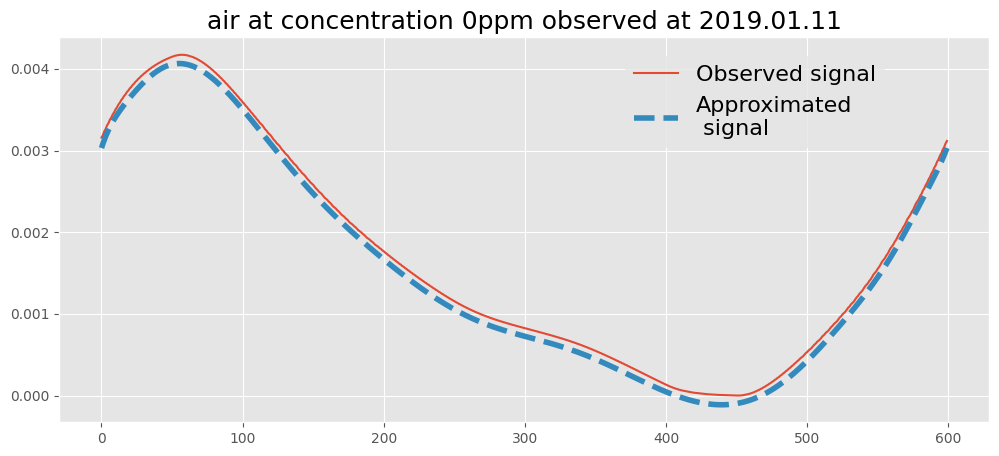

In [19]:
p = np.poly1d(X_train_coefs[row_number])
t = np.arange(0, X_train.shape[1])

plt.plot(X_train_lg10[row_number]/sum(X_train_lg10[row_number]))
plt.plot(t, p(t)-0.0001,'--',  linewidth = 4)
plt.title("{gas} at concentration {concentration}ppm observed at {experiment}".format(\
                  gas=train_log.loc[row_number]['gas'],\
                  concentration=int(train_log.loc[row_number]['concentration']),\
                  experiment= train_log.loc[row_number]['experiment']).split('_')[0],\
                  fontsize = 18)
leg = plt.legend(['Observed signal', 'Approximated\n signal'], prop={'size': 16}, loc='upper right', bbox_to_anchor=(0.9,0.98))
leg.get_frame().set_linewidth(0.0)
plt.show()

## 1.2.3 Разложение PCA (Метод главных компонент)

Разложение PCA — это метод, который используется для уменьшения размерности данных, сохраняя при этом как можно больше информации. Вот основные моменты, связанные с использованием метода главных компонент (PCA):

Применение PCA: Этот подход позволяет выявить основные направления (компоненты) в многомерных данных, которые объясняют наибольшую часть вариации. Это полезно для визуализации данных и уменьшения их размерности перед применением других методов анализа или машинного обучения.

Матрица нагрузок: Она была рассчитана на основе обучающего набора данных. Матрица нагрузок показывает, как каждая оригинальная переменная влияет на каждую из главных компонент. Это позволяет понять, какие переменные наиболее значимы для каждой компоненты.

Определение числа главных компонент: Число главных компонент было определено на основе вычисления объясненной дисперсии. Объясненная дисперсия показывает, какую долю общей вариации в данных объясняет каждая главная компонента.

Кумулятивная объясненная дисперсия: На графике ниже представлено значение кумулятивной относительной объясненной дисперсии. Этот график помогает визуально оценить, сколько информации (вариации) сохраняется при использовании определенного количества главных компонент. Обычно выбирается такое количество компонент, при котором кумулятивная объясненная дисперсия достигает определенного порога (например, 90%).

In [20]:
scaler_x = StandardScaler()
pca_model = PCA(n_components=100)

X_train_lg10_sc = scaler_x.fit_transform(X_train_lg10/np.sum(X_train_lg10, axis=1).reshape([-1,1]))
pca_model.fit(X_train_lg10_sc)

PCA(n_components=100)

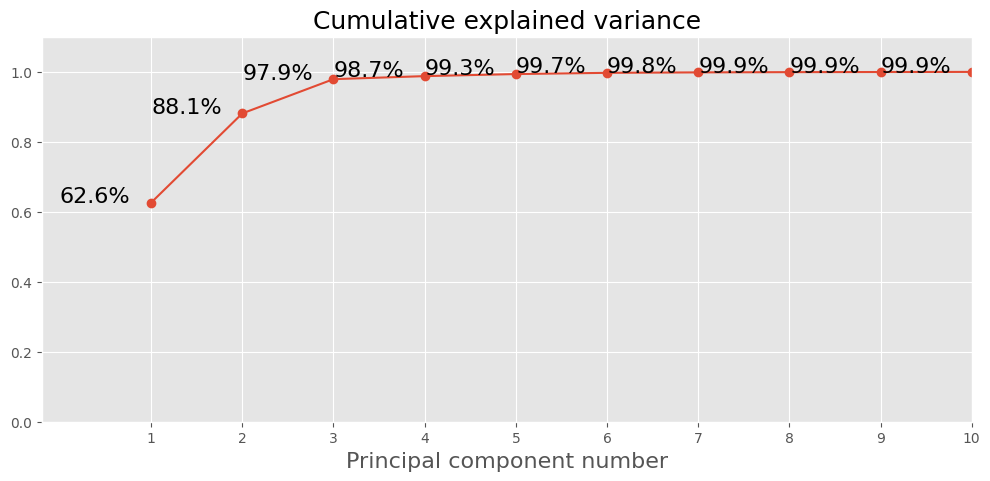

In [21]:
expl_var_cumulative = np.cumsum(pca_model.explained_variance_ratio_)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1,101), expl_var_cumulative, marker='o')

ax.set_ylim(0,1.1)
ax.set_xlim(-0.2,10)
ax.set_xticks(np.arange(1,11), minor=False)

for i,j in zip(range(10),expl_var_cumulative):
    ax.annotate("{:.1f}%".format(j*100),xy=(i,j), fontsize=16)

plt.xlabel("Principal component number", fontsize=16)
plt.title('Cumulative explained variance', fontsize=18)
plt.show()

## 1.2.4 Дискретное вейвлет-преобразование (DWT)

Дискретное вейвлет-преобразование (DWT) — это метод анализа сигналов, который позволяет разложить сигнал на компоненты с различными частотами, что особенно полезно для обработки и анализа временных рядов и изображений. Вот основные моменты, связанные с использованием DWT:

Приближающие вейвлет-коэффициенты: В этом методе использовались приближающие вейвлет-коэффициенты различных уровней. Эти коэффициенты представляют собой основные характеристики сигнала на разных масштабах и позволяют выделить важные особенности.

Материнская вейвлет: Для преобразования использовалась материнская вейвлет Даубеши 4 (Daubechies 4). Вейвлеты Даубеши известны своей способностью эффективно представлять сигналы с различной частотной характеристикой, что делает их популярными в задачах обработки сигналов.

Снижение размерности и низкочастотная фильтрация: При использовании DWT происходит снижение числа признаков (или характеристик) каждого образца, что позволяет уменьшить объем данных для дальнейшего анализа. Низкочастотная фильтрация помогает убрать шум и сохранить наиболее значимую информацию.

Приближающие коэффициенты уровней 2-7: На графиках ниже показаны приближающие коэффициенты для уровней 2-7. Как и ожидалось, количество признаков уменьшается вдвое с каждого уровня. Это свойство DWT позволяет эффективно уменьшать объем данных, сохраняя при этом важные характеристики сигнала.

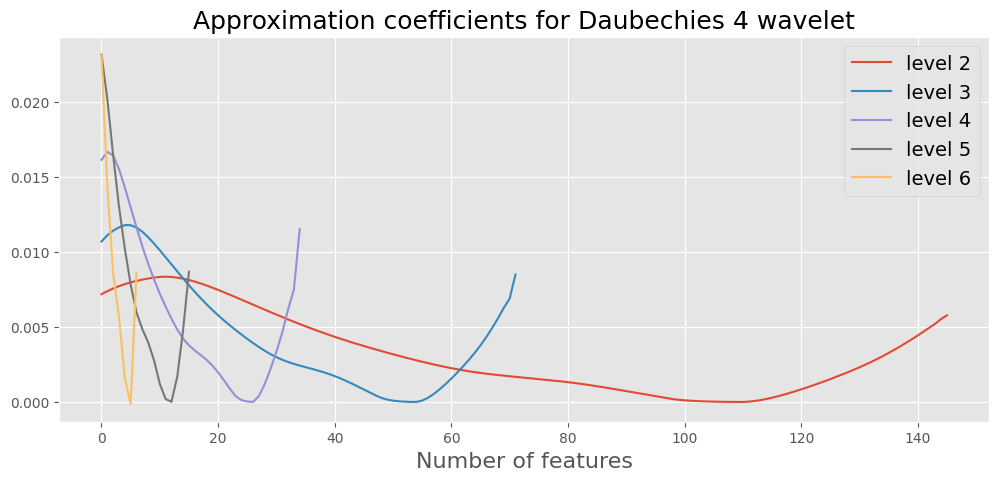

In [22]:
for lvl in range(2,7):
    dwt_sample = wavedec(X_train_lg10[row_number]/np.sum(X_train_lg10[row_number]), wavelet = 'db4', mode = 'zero', level=lvl)[0][7:-2]
    plt.plot(dwt_sample)
plt.legend(['level {}'.format(i) for i in range(2,7)], fontsize=14)
plt.xlabel("Number of features", fontsize=16)
plt.title("Approximation coefficients for Daubechies 4 wavelet", fontsize=18)
plt.show()

## 2. Создание MLP ANN в задаче машинного обучения по обнаружению газов в реальных атмосферных условиях с использованием датчиков газа на основе оксида металла

##2.1 Описание нейросети
Для создания многослойного перцептрона MLP ANN (Multilayer Perceptron Artificial Neural Network) в задаче машинного обучения по обнаружению газов в реальных атмосферных условиях с использованием датчиков газа на основе оксида металла был разработан статистический модельный подход. В данной модели использовался многослойный перцептрон с двумя скрытыми слоями, каждый из которых содержит 160 нейронов, активируемых гиперболическим тангенсом. Все данные были нормализованы с помощью стандартного масштабирования (для каждого признака по всему набору данных: среднее значение = 0, стандартное отклонение = 1), что обеспечило единообразие и стабильность входных данных. Для предотвращения переобучения модели был применен высокий уровень дропаута: 0.8 для скрытых слоев и 0.5 для выходного слоя, а также использовалась пакетная нормализация. Эти методы способствовали улучшению обобщающих способностей модели, что критически важно для точного обнаружения газов в сложных условиях окружающей среды.

In [23]:
# Преобразование в тензоры
X_train_tensor = torch.FloatTensor(X_train_lg10)
Y_train_tensor = torch.FloatTensor(Y_train) # One-hot encoded

X_val_tensor = torch.FloatTensor(X_val_lg10)
Y_val_tensor = torch.FloatTensor(Y_val) # One-hot encoded

X_test_tensor = torch.FloatTensor(X_test_lg10)
Y_test_tensor = torch.FloatTensor(Y_test) # One-hot encoded

##2.2 Описание входных данных

`X_train_lg10` тренировочные данные \
`Y_train` метки для тренировочных данных (one-hot encoded)

`X_test_lg10`  тестовые данные \
`Y_test` метки для тестовых данных (one-hot encoded)

`X_val_lg10` валидационные данные \
`Y_val` метки для валидационных данных (one-hot encoded)

In [24]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

###2.3 Обучение модели
Для начала проведем обучение и тестировку модели **без масштабирования**. Масштабирование применим позже

In [25]:
# Определение модели MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate_hidden=0.8, dropout_rate_output=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.tanh1 = nn.Tanh()
        self.dropout1 = nn.Dropout(dropout_rate_hidden)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.tanh2 = nn.Tanh()
        self.dropout2 = nn.Dropout(dropout_rate_hidden)

        self.fc3 = nn.Linear(hidden_size, output_size)
        self.dropout3 = nn.Dropout(dropout_rate_output)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.tanh1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.tanh2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.dropout3(x)
        return x

# Функция для вычисления метрик
def calculate_metrics(model, val_loader):
    model.eval()
    all_targets = []
    all_predictions = []
    val_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, torch.argmax(targets, dim=1)).item()
            _, predicted = torch.max(outputs, 1)
            all_targets.extend(torch.argmax(targets, dim=1).tolist())
            all_predictions.extend(predicted.tolist())

    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # Вычисление и вывод метрик
    print("\nClassification Report:")
    print(classification_report(all_targets, all_predictions, target_names=["Air", "Methane", "Propane"]))

    return all_targets, all_predictions

# Функция для построения матрицы путаницы
def plot_confusion_matrix(all_targets, all_predictions):
    cm = confusion_matrix(all_targets, all_predictions)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Преобразование в проценты


    # Вывод абсолютных значений матрицы путаницы
    print("Confusion Matrix (absolute values):")
    print(cm)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', annot_kws={"size": 16},
                xticklabels=["Air", "Methane", "Propane"],
                yticklabels=["Air", "Methane", "Propane"])
    plt.ylabel('Set gas mixture')
    plt.xlabel('Predicted')
    plt.title(SENSOR)
    plt.show()

# Функция для построения графиков потерь и точности
def plot_loss_accuracy(losses, accuracies):
    plt.figure(figsize=(12, 5))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss', color='red')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy', color='blue')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Функция обучения и валидации
def train_and_validate(model, train_loader, val_loader, epochs_train=100, lr=0.001):
    criterion = nn.CrossEntropyLoss()  # Для многоклассовой классификации
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Инициализация списков для хранения значений потерь и точности
    losses = []
    accuracies = []

    # Обучение
    model.train()
    for epoch in range(epochs_train):
        epoch_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(targets, dim=1))  # Преобразуем OHE в индексы классов
            loss.backward()
            optimizer.step()

            # Суммируем потери для текущей эпохи
            epoch_loss += loss.item()

            # Вычисление точности
            _, predicted = torch.max(outputs, 1)
            total_predictions += targets.size(0)
            correct_predictions += (predicted == torch.argmax(targets, dim=1)).sum().item()

        # Вычисляем средние значения потерь и точности за эпоху
        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct_predictions / total_predictions

        # Сохраняем значения потерь и точности
        losses.append(avg_loss)
        accuracies.append(accuracy)

        #print(f"Epoch {epoch + 1}/{epochs_train}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Валидация
    all_targets, all_predictions = calculate_metrics(model, val_loader)
    plot_confusion_matrix(all_targets, all_predictions)
    plot_loss_accuracy(losses, accuracies)



Validation Loss: 0.0370

Classification Report:
              precision    recall  f1-score   support

         Air       0.98      1.00      0.99       793
     Methane       1.00      0.96      0.98       371
     Propane       1.00      1.00      1.00       384

    accuracy                           0.99      1548
   macro avg       0.99      0.99      0.99      1548
weighted avg       0.99      0.99      0.99      1548

Confusion Matrix (absolute values):
[[793   0   0]
 [ 14 357   0]
 [  0   0 384]]


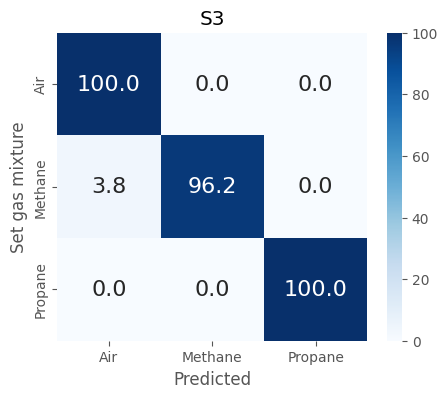

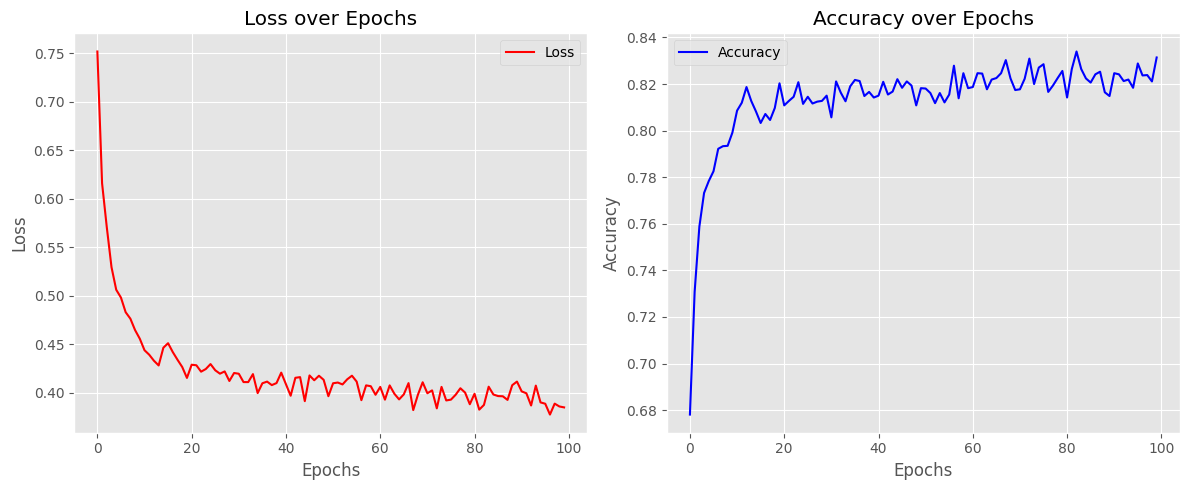

In [26]:
# Main script
if __name__ == "__main__":

    # Initialize model
    input_size = X_train.shape[1]
    hidden_size = 160
    output_size = 3  # Количество классов
    model = MLP(input_size, hidden_size, output_size)
# Train
train_and_validate(model, train_loader, val_loader)

##№2.3.1 Результаты обучения
Графики **Loss** и **Accuracy**:

**Loss:** Значение функции потерь (Loss) снижается с 0.75 до 0.38 по мере обучения. Это говорит о том, что модель становится лучше в предсказании целевых значений, и ошибки уменьшаются. Снижение Loss с каждой эпохой является положительным признаком, указывающим на то, что модель обучается. \
**Accuracy:** Значение точности (Accuracy) увеличивается с 0.68 до 0.83, что также указывает на улучшение производительности модели. Это означает, что модель становится более точной в своих предсказаниях. \
**Validation Loss:** Значение Validation Loss составляет 0.0370. Это очень низкое значение, что указывает на то, что модель хорошо обобщает данные и не переобучена. Это хороший знак, так как низкое значение потерь на валидационном наборе данных свидетельствует о том, что модель не только хорошо работает на обучающем наборе, но и способна обрабатывать новые данные.

**Classification Report на валидации**
Precision, Recall, F1-score:
Для класса "Air" и "Propane" показатели близки к 1.00, что указывает на отличные результаты.
Для "Methane" precision составляет 1.00, но recall чуть ниже (0.96), что означает, что модель хорошо распознает метан, но пропускает некоторые случаи.
Accuracy: Общая точность на валидационном наборе составляет 0.99, что указывает на то, что модель практически безошибочно классифицирует примеси газа.\
**Confusion Matrix на валидации**
Матрица путаницы показывает, что модель правильно классифицировала большинство образцов, но есть некоторые ошибки, особенно в классе "Methane", где 14 образцов были неправильно классифицированы как "Air".


##2.4 Тестирование модели
Произведем тестирование модели на независимой тестировочной выборке

In [27]:
# Функция тестирования модели
def test_model(model, test_loader):
    all_targets, all_predictions = calculate_metrics(model, test_loader)
    plot_confusion_matrix(all_targets, all_predictions)

Validation Loss: 0.2941

Classification Report:
              precision    recall  f1-score   support

         Air       0.88      1.00      0.93      3240
     Methane       0.87      0.76      0.81      1620
     Propane       1.00      0.86      0.92      1614

    accuracy                           0.90      6474
   macro avg       0.92      0.87      0.89      6474
weighted avg       0.91      0.90      0.90      6474

Confusion Matrix (absolute values):
[[3225   12    3]
 [ 389 1230    1]
 [  49  175 1390]]


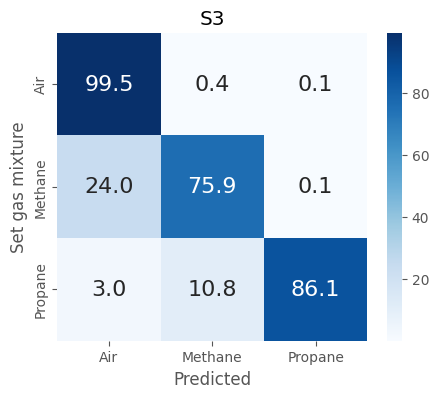

In [28]:
test_model(model, test_loader)

**Precision и Recall:** Показатели точности и полноты для класса "Air" и "Propane" остаются высокими, но для "Methane" наблюдается снижение. Precision равен 0.87 и Recall 0.76, что указывает на то, что модель имеет трудности с распознаванием метана на тестовой выборке. \
**Accuracy:** Общая точность составляет 0.90, что все еще является хорошим результатом, хотя и ниже, чем на валидации. \
**Confusion Matrix** на тестовой выборке:
Матрица путаницы показывает, что модель иногда путает "Methane" с "Air" и "Propane", что подтверждает результаты отчета о классификации.

#Выводы
Модель показывает отличные результаты на валидационном наборе данных, с высокой точностью и малой потерей, что указывает на хорошее обобщение.
Однако, при тестировании на независимой выборке, производительность модели несколько ухудшилась, особенно для класса "Methane". Это может быть связано с тем, что тестовые данные имеют другие характеристики, отличные от обучающих и валидационных данных.
В последствии будут выполнены следующие шаги, которые можно предпринять для улучшения производительности модели, включая тестирование влияния различных методов предварительной обработки данных и анализ архитектуры сети.

**Тестирование влияния масштабирования и предварительной обработки данных**

**Масштабирование данных:**
Применение методов масштабирования (например, Min-Max Scaling или Standardization) может помочь улучшить производительность модели, особенно если данные имеют разные диапазоны значений. Это может привести к более быстрому и стабильному обучению.

**Полиномиальная аппроксимация:**
Использование полиномиальных признаков может помочь модели захватить нелинейные зависимости в данных. Это может быть полезно, особенно если данные имеют сложные отношения между признаками.

**Разложение PCA (Метод главных компонент):**
PCA может помочь уменьшить размерность данных, сохраняя при этом наиболее значимую информацию. Это может улучшить обобщающую способность модели и уменьшить время обучения, особенно если у вас много признаков.

**Дискретное вейвлет-преобразование (DWT):**
DWT может использоваться для извлечения признаков из временных рядов или сигналов. Это может помочь выявить важные характеристики данных, которые могут быть полезны для классификации.
Другие методы предварительной обработки:

**Аугментация данных: Создание дополнительных данных путем применения различных трансформаций может помочь улучшить обобщающую способность модели.**

**Анализ возможностей улучшения архитектуры сети** \
**Изменение архитектуры:**

**Добавление слоев:** Увеличение глубины сети может помочь модели лучше захватывать сложные зависимости в данных. Однако это также может привести к переобучению, поэтому важно следить за значениями Loss и Accuracy на валидации.
Использование различных типов слоев: Например, использование слоев Dropout для предотвращения переобучения, или слоев Batch Normalization для ускорения обучения и улучшения стабильности.
Настройка гиперпараметров:

**Проведение поиска по сетке (Grid Search) или случайного поиска (Random Search)** для нахождения оптимальных значений гиперпараметров, таких как скорость обучения, размер батча и количество нейронов в каждом слое.
Использование предобученных моделей:

**Объединение моделей (Ensemble Learning):**

Применение методов ансамблирования, таких как Bagging или Boosting, может помочь улучшить точность и устойчивость модели, комбинируя предсказания нескольких моделей.